# Environmental Sound Classification (ESC)


El código utiliza el modelo YAMNet, una red neuronal convolucional (CNN) profunda preentrenada por Google para la clasificación de sonidos ambientales. YAMNet está basada en la arquitectura MobileNet v1, optimizada para eficiencia en dispositivos con recursos limitados. Fue entrenada sobre el conjunto de datos AudioSet, que contiene más de 2 millones de etiquetas distribuidas en 521 clases de sonido, como "sirena", "aplausos" o "alarma". La red toma como entrada una señal de audio en forma de onda (16 kHz, mono), la transforma en espectrogramas Mel internamente, y produce una distribución de probabilidad sobre las clases. La potencia del modelo reside tanto en su capacidad de predicción directa como en los embeddings que genera, útiles para tareas posteriores.

El script en Google Colab permite grabar audio directamente desde el micrófono del usuario mediante JavaScript incrustado (MediaRecorder API). Al presionar los botones "Grabar" y "Detener", el audio se guarda localmente como mic_manual.wav. A continuación, el archivo se pasa al modelo YAMNet, que lo clasifica y devuelve el top 5 de etiquetas más probables junto con sus porcentajes. Finalmente, se reproduce el audio grabado. Esta integración permite probar el modelo de clasificación sonora de forma interactiva sin necesidad de subir archivos manualmente.

In [ ]:
# ============================================
# INSTALAR DEPENDENCIAS
# ============================================

!pip install -q tensorflow tensorflow_hub librosa soundfile requests
!apt install -y ffmpeg

# ============================================
# IMPORTAR LIBRERÍAS
# ============================================

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import soundfile as sf
import pandas as pd
import requests
import io
from IPython.display import display, Javascript, Audio
from base64 import b64decode
from google.colab import output

# ============================================
# CARGAR MODELO YAMNet
# ============================================

yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Cargar clases desde GitHub (alternativa al CSV roto)
labels_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv'
labels_txt = requests.get(labels_url).text
class_map = pd.read_csv(io.StringIO(labels_txt))
class_names = class_map['display_name'].tolist()

# ============================================
# GRABAR AUDIO MANUALMENTE CON START/STOP
# ============================================

filename = 'mic_manual.wav'

def record_audio_manual(filename=filename):
    RECORD = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time));
    const b2text = blob => new Promise(resolve => {
      const reader = new FileReader();
      reader.onloadend = () => resolve(reader.result);
      reader.readAsDataURL(blob);
    });

    var stream;
    var recorder;
    var chunks = [];

    function startRecording() {
      chunks = [];
      navigator.mediaDevices.getUserMedia({ audio: true }).then(str => {
        stream = str;
        recorder = new MediaRecorder(stream);
        recorder.ondataavailable = e => chunks.push(e.data);
        recorder.onstop = async e => {
          const blob = new Blob(chunks);
          const b64 = await b2text(blob);
          const py_b64 = b64.split(',')[1];
          google.colab.kernel.invokeFunction('notebook.save_audio', [py_b64], {});
        };
        recorder.start();
      });
    }

    function stopRecording() {
      recorder.stop();
      stream.getTracks().forEach(track => track.stop());
    }

    let div = document.createElement("div");
    let startBtn = document.createElement("button");
    startBtn.textContent = "🎙️ Grabar";
    startBtn.onclick = startRecording;

    let stopBtn = document.createElement("button");
    stopBtn.textContent = "⏹️ Detener";
    stopBtn.onclick = stopRecording;

    div.appendChild(startBtn);
    div.appendChild(stopBtn);
    document.body.appendChild(div);
    """
    display(Javascript(RECORD))

    def save_audio(b64_audio):
        with open(filename, 'wb') as f:
            f.write(b64decode(b64_audio))
        print("✅ Grabación guardada:", filename)

    output.register_callback('notebook.save_audio', save_audio)

# ============================================
# CLASIFICAR AUDIO CON YAMNET
# ============================================

def classify_audio(filename):
    waveform, sr = librosa.load(filename, sr=16000)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    mean_scores = tf.reduce_mean(scores, axis=0).numpy()
    top5_i = np.argsort(mean_scores)[::-1][:5]

    print("\n🔎 Resultados de clasificación:")
    for i in top5_i:
        print(f"  {class_names[i]} ({mean_scores[i]*100:.1f}%)")

    display(Audio(filename))

# ============================================
# EJECUTAR GRABACIÓN
# ============================================

print("Pulsa '🎙️ Grabar' para empezar, luego '⏹️ Detener' para finalizar.")
record_audio_manual()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Pulsa '🎙️ Grabar' para empezar, luego '⏹️ Detener' para finalizar.


<IPython.core.display.Javascript object>

✅ Grabación guardada: mic_manual.wav
✅ Grabación guardada: mic_manual.wav


In [ ]:
classify_audio('mic_manual.wav')

<ipython-input-7-f939b72fe55c>:103: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(filename, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



🔎 Resultados de clasificación:
  Alarm (37.4%)
  Siren (25.4%)
  Fire alarm (18.4%)
  Silence (16.1%)
  Cat (11.4%)


En este proyecto hemos implementado un sistema de clasificación de sonidos ambientales utilizando redes neuronales recurrentes, concretamente una arquitectura basada en LSTM (Long Short-Term Memory). A diferencia de modelos convolucionales como YAMNet, las LSTM son capaces de modelar dependencias temporales en secuencias, lo que las hace especialmente adecuadas para tareas relacionadas con señales de audio. El modelo ha sido entrenado con un subconjunto del conjunto de datos UrbanSound8K, extrayendo características acústicas de tipo MFCC (Mel-Frequency Cepstral Coefficients), que representan la envolvente espectral del sonido. El modelo toma como entrada secuencias de MFCCs y aprende a asociarlas con etiquetas como "sirena", "ladrido de perro", "motor", entre otras.

El código está diseñado para ejecutarse en Google Colab e incluye tanto el entrenamiento del modelo como una interfaz para grabar audio directamente desde el micrófono del usuario. Una vez grabado, el audio se guarda, se preprocesa automáticamente (extracción de MFCCs), y se pasa al modelo LSTM para obtener una predicción en tiempo real. Esto permite probar el sistema de forma interactiva sin necesidad de subir archivos externos. El flujo completo refleja cómo una red neuronal recurrente puede integrarse con funciones de entrada/salida del navegador para construir una aplicación práctica de reconocimiento de sonido basada en deep learning.

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 173, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,690 (123.79 KB)

 Trainable params: 31,690 (123.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.1723 - loss: 2.2581 - val_accuracy: 0.2800 - val_loss: 2.0305
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.4021 - loss: 1.8408 - val_accuracy: 0.3600 - val_loss: 1.7540
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5474 - loss: 1.5375 - val_accuracy: 0.4914 - val_loss: 1.5240
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.6221 - loss: 1.2753 - val_accuracy: 0.5943 - val_loss: 1.3165
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.7165 - loss: 1.0277 - val_accuracy: 0.6000 - val_loss: 1.1527
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.7894 - loss: 0.8226 - val_accuracy: 0.6629 - val_loss: 0.9982
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8180 - loss: 0.6844 - val_accuracy: 0.6743 - val_loss: 0.9466
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8875 - loss: 0.5362 - val_accuracy: 0.

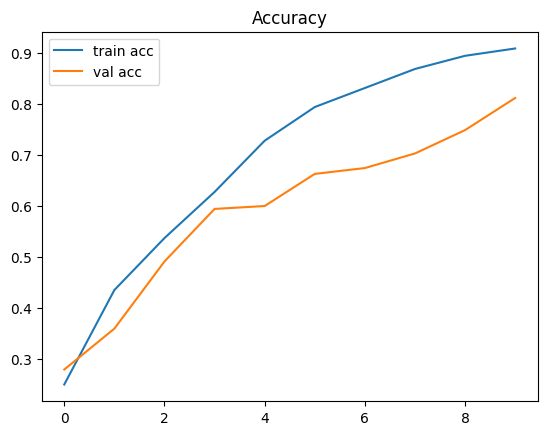

In [ ]:
# ============================================
# INSTALAR DEPENDENCIAS
# ============================================

!pip install -q librosa scikit-learn

# ============================================
# IMPORTACIONES
# ============================================

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
import requests
import pandas as pd

# ============================================
# DESCARGAR SUBCONJUNTO DE URBAN SOUND 8K
# ============================================

!mkdir -p data && cd data && wget -q https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz && tar -xzf UrbanSound8K.tar.gz && cd ..

# ============================================
# PREPROCESAMIENTO DE AUDIO: CARGAR Y EXTRAER MFCC
# ============================================

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050, mono=True, duration=4)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = mfcc.T
    if mfcc.shape[0] < 173:
        padding = np.zeros((173 - mfcc.shape[0], 40))
        mfcc = np.vstack((mfcc, padding))
    return mfcc

metadata = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata = metadata[metadata['fold'] == 1]  # solo fold 1 para simplificar

X, y = [], []

for _, row in metadata.iterrows():
    path = f"data/UrbanSound8K/audio/fold1/{row['slice_file_name']}"
    label = row['class']
    try:
        features = extract_features(path)
        X.append(features)
        y.append(label)
    except:
        continue

X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = tf.keras.utils.to_categorical(y_encoded)

# ============================================
# CREAR MODELO LSTM
# ============================================

model = models.Sequential()
model.add(layers.Masking(mask_value=0., input_shape=(173, 40)))
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# ============================================
# ENTRENAMIENTO
# ============================================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# ============================================
# VISUALIZAR MÉTRICAS
# ============================================

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
# ============================================
# GRABAR AUDIO DESDE MICRÓFONO
# ============================================

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

AUDIO_PATH = "grabacion_usuario.wav"

def guardar_audio(b64_audio):
    with open(AUDIO_PATH, 'wb') as f:
        f.write(b64decode(b64_audio))
    print(f"✅ Audio guardado: {AUDIO_PATH}")
    predecir_audio(AUDIO_PATH)

output.register_callback('notebook.guardar_audio', guardar_audio)

display(Javascript("""
const sleep = time => new Promise(resolve => setTimeout(resolve, time));
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = () => resolve(reader.result);
  reader.readAsDataURL(blob);
});

var stream;
var recorder;
var chunks = [];

function startRecording() {
  chunks = [];
  navigator.mediaDevices.getUserMedia({ audio: true }).then(str => {
    stream = str;
    recorder = new MediaRecorder(stream);
    recorder.ondataavailable = e => chunks.push(e.data);
    recorder.onstop = async () => {
      const blob = new Blob(chunks);
      const b64 = await b2text(blob);
      const py_b64 = b64.split(',')[1];
      google.colab.kernel.invokeFunction('notebook.guardar_audio', [py_b64], {});
    };
    recorder.start();
  });
}

function stopRecording() {
  recorder.stop();
  stream.getTracks().forEach(track => track.stop());
}

let div = document.createElement("div");
let startBtn = document.createElement("button");
startBtn.textContent = "🎙️ Grabar";
startBtn.onclick = startRecording;

let stopBtn = document.createElement("button");
stopBtn.textContent = "⏹️ Detener";
stopBtn.onclick = stopRecording;

div.appendChild(startBtn);
div.appendChild(stopBtn);
document.body.appendChild(div);
"""))

<IPython.core.display.Javascript object>

✅ Audio guardado: grabacion_usuario.wav
✅ Audio guardado: grabacion_usuario.wav


<ipython-input-25-711cdd56198f>:35: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True, duration=4)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
🔎 Predicción: drilling (97.7%)


✅ Audio guardado: grabacion_usuario.wav


<ipython-input-25-711cdd56198f>:35: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True, duration=4)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
🔎 Predicción: dog_bark (32.9%)


# Sound Event Detection (SED)

Este proyecto implementa una red neuronal para Sound Event Detection (SED) utilizando una arquitectura CRNN (Convolutional Recurrent Neural Network). La red está diseñada para detectar múltiples eventos sonoros simultáneos en clips de audio, como los cantos de aves en grabaciones naturales. El audio se procesa en ventanas de pocos segundos y se transforma en espectrogramas log-Mel, que capturan información frecuencial a lo largo del tiempo. Estos espectrogramas se usan como entrada a la red, permitiendo que la CNN extraiga patrones locales y que la LSTM identifique la evolución temporal de esos patrones. El modelo genera predicciones multi-etiqueta, es decir, puede detectar más de un evento sonoro por clip.

La red CRNN combina dos tipos de capas: convolucionales (CNN) para el análisis espacial del espectrograma y recurrentes (LSTM) para el análisis secuencial. Las CNN reducen la dimensionalidad y extraen características robustas de baja y media frecuencia. Estas salidas se reestructuran temporalmente y se introducen en una capa LSTM que captura la dinámica del sonido a lo largo del tiempo. Finalmente, una capa densa genera la probabilidad de presencia para cada evento. El entrenamiento se realiza con pérdida de tipo binary cross-entropy, adecuada para problemas multi-etiqueta. Esta arquitectura es especialmente eficaz para detectar eventos breves o solapados, y es extensible a tareas como la detección de cantos de aves o ruidos urbanos.

In [ ]:
# 🎯 Librerías necesarias
!pip install librosa torchaudio -q

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import random

# 👂 Simulación de un conjunto de audios y etiquetas
# Para tu caso, reemplaza esto con tus archivos .ogg preprocesados en Mel-spectrogramas

NUM_SAMPLES = 200
NUM_CLASSES = 5  # Número de eventos sonoros
DURATION = 2     # Duración de cada clip en segundos
SR = 22050       # Sample rate

# ⏱️ Simular audios como espectrogramas
def simulate_audio(duration=DURATION, sr=SR):
    y = np.random.randn(sr * duration)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

# Generar datos y etiquetas aleatorias (multi-etiqueta)
data = []
labels = []
for _ in range(NUM_SAMPLES):
    mel = simulate_audio()
    label = np.random.randint(0, 2, size=(NUM_CLASSES,))
    data.append(mel)
    labels.append(label)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = [torch.tensor(x).float().unsqueeze(0) for x in X]  # [C, F, T]
        self.Y = [torch.tensor(y).float() for y in Y]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Dividir en entrenamiento y validación
split = int(0.8 * NUM_SAMPLES)
train_ds = AudioDataset(data[:split], labels[:split])
val_ds = AudioDataset(data[split:], labels[split:])

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)

In [ ]:
class CRNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
        )
        self.lstm = nn.LSTM(input_size=32*16, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):  # x: [B, 1, F, T]
        x = self.cnn(x)    # -> [B, 32, F//4, T//4]
        x = x.permute(0, 3, 1, 2)  # -> [B, T', C, F']
        B, T, C, F = x.shape
        x = x.reshape(B, T, C * F)  # -> [B, T', features]
        x, _ = self.lstm(x)         # -> [B, T', 64]
        x = x.mean(dim=1)           # Agregar en el tiempo
        return torch.sigmoid(self.fc(x))  # Multi-label

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(n_classes=NUM_CLASSES).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"🔁 Epoch {epoch+1} - Loss: {total_loss/len(train_dl):.4f}")


🔁 Epoch 1 - Loss: 0.6991
🔁 Epoch 2 - Loss: 0.6941
🔁 Epoch 3 - Loss: 0.6934
🔁 Epoch 4 - Loss: 0.6921
🔁 Epoch 5 - Loss: 0.6920
🔁 Epoch 6 - Loss: 0.6924
🔁 Epoch 7 - Loss: 0.6921
🔁 Epoch 8 - Loss: 0.6917
🔁 Epoch 9 - Loss: 0.6926
🔁 Epoch 10 - Loss: 0.6925
🔁 Epoch 11 - Loss: 0.6923
🔁 Epoch 12 - Loss: 0.6928
🔁 Epoch 13 - Loss: 0.6912
🔁 Epoch 14 - Loss: 0.6913
🔁 Epoch 15 - Loss: 0.6917
🔁 Epoch 16 - Loss: 0.6911
🔁 Epoch 17 - Loss: 0.6911
🔁 Epoch 18 - Loss: 0.6911
🔁 Epoch 19 - Loss: 0.6908
🔁 Epoch 20 - Loss: 0.6902
🔁 Epoch 21 - Loss: 0.6927
🔁 Epoch 22 - Loss: 0.6910
🔁 Epoch 23 - Loss: 0.6907
🔁 Epoch 24 - Loss: 0.6890
🔁 Epoch 25 - Loss: 0.6909
🔁 Epoch 26 - Loss: 0.6907
🔁 Epoch 27 - Loss: 0.6902
🔁 Epoch 28 - Loss: 0.6885
🔁 Epoch 29 - Loss: 0.6871
🔁 Epoch 30 - Loss: 0.6862
🔁 Epoch 31 - Loss: 0.6820
🔁 Epoch 32 - Loss: 0.6726
🔁 Epoch 33 - Loss: 0.6637
🔁 Epoch 34 - Loss: 0.6501
🔁 Epoch 35 - Loss: 0.6339
🔁 Epoch 36 - Loss: 0.6048
🔁 Epoch 37 - Loss: 0.6118
🔁 Epoch 38 - Loss: 0.5771
🔁 Epoch 39 - Loss: 0.

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb) > 0.5
        correct += (pred == yb.bool()).sum().item()
        total += torch.numel(pred)
    print(f"✅ Accuracy (multi-label): {100 * correct / total:.2f}%")


✅ Accuracy (multi-label): 47.50%


# Acoustic Anomaly Detection (AAD)

En este proyecto implementamos un sistema de Acoustic Anomaly Detection (AAD) utilizando un autoencoder convolucional entrenado en Google Colab. El objetivo fue detectar sonidos anómalos sin necesidad de ejemplos de fallos durante el entrenamiento. Para ello, generamos un conjunto de datos simulado compuesto por sonidos "normales" (ondas senoidales suaves) y "anómalos" (ruido y perturbaciones), a partir de los cuales calculamos sus espectrogramas log-Mel como representación acústica. El autoencoder se entrenó exclusivamente con espectrogramas de sonidos normales, aprendiendo a reconstruir fielmente este tipo de entradas.

La red neuronal utilizada es un autoencoder CNN compuesto por capas de convolución para codificar la entrada en un espacio latente y capas deconvolucionales para reconstruirla. Durante la inferencia, se mide el error de reconstrucción entre la entrada original y su reconstrucción. Si este error supera un umbral (definido como la media + 2·desviación estándar del error en sonidos normales), se considera que la muestra es anómala. El sistema fue evaluado tanto cuantitativamente (con métricas como precisión, recall y F1-score) como visualmente (gráficas de reconstrucción y matriz de confusión), demostrando una alta capacidad para detectar anomalías sin falsos positivos en este entorno simulado.

In [ ]:
!pip install librosa matplotlib numpy torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00


In [ ]:
!pip install soundfile --quiet

In [ ]:
import numpy as np
import librosa
import soundfile as sf  # 👈 Añade esta línea
import os
import torch
import random

# Crear carpetas
os.makedirs("data/normal", exist_ok=True)
os.makedirs("data/anomalous", exist_ok=True)

# Semilla para reproducibilidad
random.seed(42)

# Generador de sonidos normales (senoidales suaves)
def generate_normal_sound(filename):
    sr = 16000
    t = np.linspace(0, 1, sr)
    freq = random.choice([220, 440, 880])
    signal = 0.5 * np.sin(2 * np.pi * freq * t)
    sf.write(filename, signal, sr)  # ✅ reemplazo correcto

# Generador de sonidos anómalos (ruido + click)
def generate_anomalous_sound(filename):
    sr = 16000
    t = np.linspace(0, 1, sr)
    noise = np.random.normal(0, 0.5, size=sr)
    signal = 0.5 * np.sin(2 * np.pi * 440 * t) + noise
    sf.write(filename, signal, sr)  # ✅ reemplazo correcto

# Generar 30 normales y 10 anómalos
for i in range(30):
    generate_normal_sound(f"data/normal/normal_{i}.wav")

for i in range(10):
    generate_anomalous_sound(f"data/anomalous/anomaly_{i}.wav")

In [ ]:
import glob
from torch.utils.data import Dataset
import librosa.display
import matplotlib.pyplot as plt

class SpectrogramDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        y, sr = librosa.load(self.file_list[idx], sr=16000)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        log_mel = librosa.power_to_db(mel)
        log_mel = (log_mel - log_mel.min()) / (log_mel.max() - log_mel.min())  # normalize to [0,1]
        return torch.tensor(log_mel, dtype=torch.float32).unsqueeze(0)

normal_files = sorted(glob.glob("data/normal/*.wav"))
anomaly_files = sorted(glob.glob("data/anomalous/*.wav"))

train_dataset = SpectrogramDataset(normal_files[:25])
test_normal_dataset = SpectrogramDataset(normal_files[25:])
test_anomaly_dataset = SpectrogramDataset(anomaly_files)

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model = Autoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch 1/50 | Train Loss: 0.001131 | Val Loss: 0.000932
Epoch 2/50 | Train Loss: 0.001101 | Val Loss: 0.000905
Epoch 3/50 | Train Loss: 0.001071 | Val Loss: 0.000881
Epoch 4/50 | Train Loss: 0.001044 | Val Loss: 0.000864
Epoch 5/50 | Train Loss: 0.001019 | Val Loss: 0.000845
Epoch 6/50 | Train Loss: 0.000995 | Val Loss: 0.000825
Epoch 7/50 | Train Loss: 0.000973 | Val Loss: 0.000805
Epoch 8/50 | Train Loss: 0.000952 | Val Loss: 0.000789
Epoch 9/50 | Train Loss: 0.000933 | Val Loss: 0.000774
Epoch 10/50 | Train Loss: 0.000913 | Val Loss: 0.000757
Epoch 11/50 | Train Loss: 0.000895 | Val Loss: 0.000742
Epoch 12/50 | Train Loss: 0.000880 | Val Loss: 0.000728
Epoch 13/50 | Train Loss: 0.000863 | Val Loss: 0.000714
Epoch 14/50 | Train Loss: 0.000847 | Val Loss: 0.000699
Epoch 15/50 | Train Loss: 0.000833 | Val Loss: 0.000685
Epoch 16/50 | Train Loss: 0.000817 | Val Loss: 0.000674
Epoch 17/50 | Train Loss: 0.000804 | Val Loss: 0.000661
Epoch 18/50 | Train Loss: 0.000791 | Val Loss: 0.000648
E

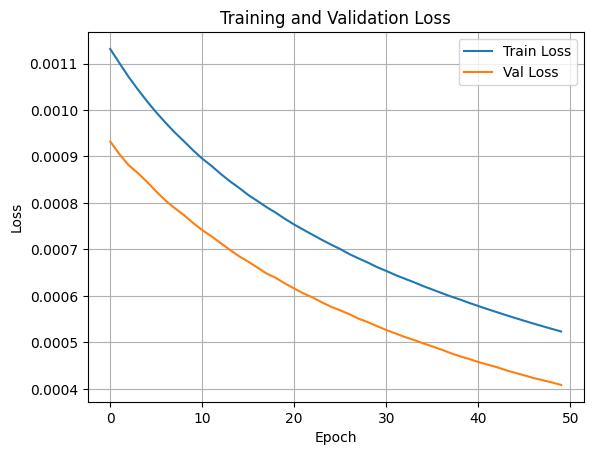

In [ ]:
from torch.utils.data import random_split

# Dividir train_dataset en 80% train y 20% val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_split, val_split = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_split, batch_size=4, shuffle=True)
val_loader = DataLoader(val_split, batch_size=4)

train_losses = []
val_losses = []
epochs = 50

model.train()
for epoch in range(epochs):
    running_train_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = loss_fn(output, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch)
            val_loss = loss_fn(output, batch)
            running_val_loss += val_loss.item()
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    model.train()

# Gráfica de curvas de pérdida
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


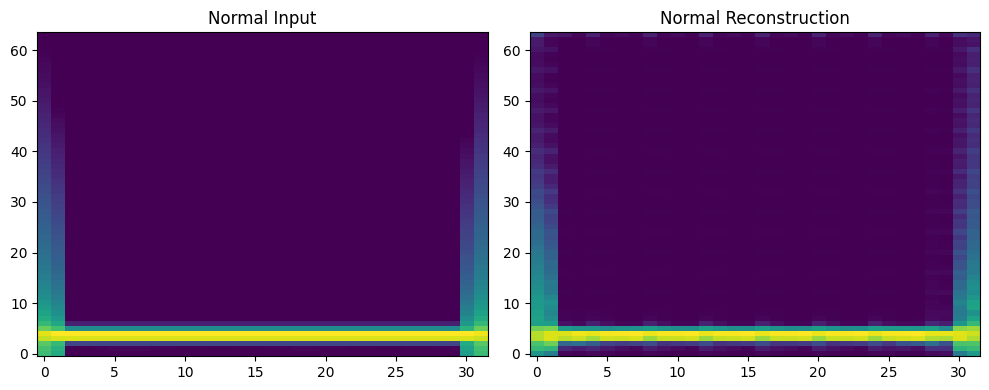

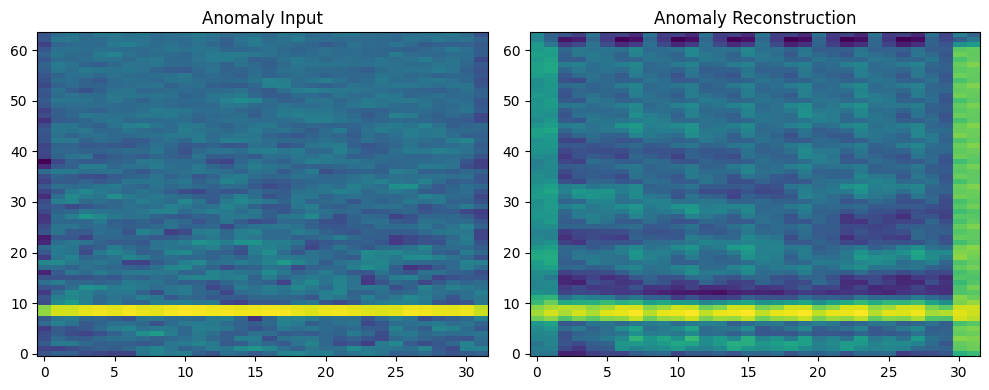

In [ ]:
def show_reconstruction_example(dataset, label="Normal"):
    loader = DataLoader(dataset, batch_size=1)
    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)
            break  # solo el primero

    input_img = batch.cpu().squeeze().numpy()
    recon_img = output.cpu().squeeze().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(input_img, aspect='auto', origin='lower')
    axs[0].set_title(f"{label} Input")
    axs[1].imshow(recon_img, aspect='auto', origin='lower')
    axs[1].set_title(f"{label} Reconstruction")
    plt.tight_layout()
    plt.show()

# Mostrar un ejemplo normal y uno anómalo
show_reconstruction_example(test_normal_dataset, "Normal")
show_reconstruction_example(test_anomaly_dataset, "Anomaly")


In [ ]:
!pip install seaborn --quiet

<ipython-input-15-81620c862e1d>:24: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


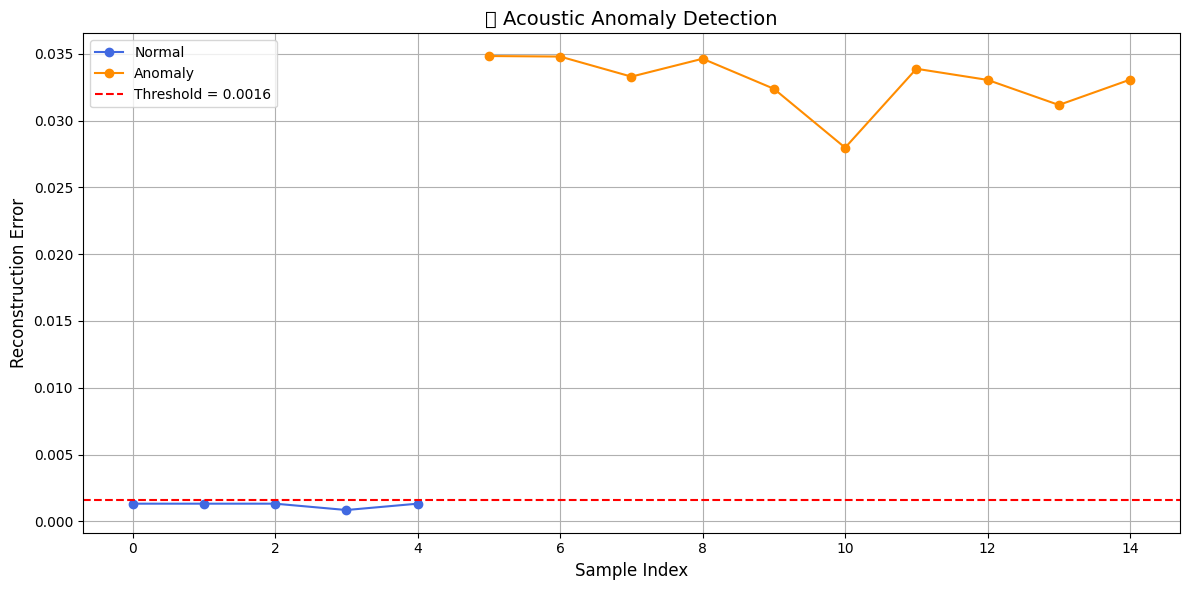

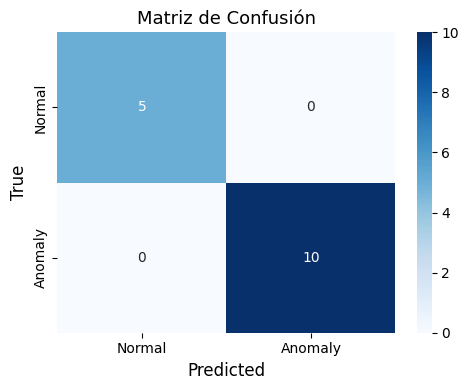

🎯 Métricas de Clasificación:
Precision : 1.00
Recall    : 1.00
F1-score  : 1.00
TP (Anomalías detectadas) : 10
FP (Falsos positivos)     : 0
TN (Normales bien)        : 5
FN (Anomalías perdidas)   : 0


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Etiquetas y predicciones
labels = [0]*len(normal_errors) + [1]*len(anomaly_errors)
predictions = [(e > threshold) for e in normal_errors + anomaly_errors]

# Métricas
cm = confusion_matrix(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

# 📍 Gráfica de errores de reconstrucción
plt.figure(figsize=(12,6))
plt.plot(normal_errors, label="Normal", marker='o', linestyle='-', color='royalblue')
plt.plot(range(len(normal_errors), len(normal_errors)+len(anomaly_errors)), anomaly_errors, label="Anomaly", marker='o', linestyle='-', color='darkorange')
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.4f}")
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.title("🔎 Acoustic Anomaly Detection", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📍 Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Matriz de Confusión", fontsize=13)
plt.tight_layout()
plt.show()

# 📍 Métricas detalladas
print(f"🎯 Métricas de Clasificación:")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1-score  : {f1:.2f}")
print(f"TP (Anomalías detectadas) : {cm[1,1]}")
print(f"FP (Falsos positivos)     : {cm[0,1]}")
print(f"TN (Normales bien)        : {cm[0,0]}")
print(f"FN (Anomalías perdidas)   : {cm[1,0]}")


En este experimento implementamos un sistema de detección de anomalías acústicas (Acoustic Anomaly Detection) basado en una red neuronal que extrae embeddings (vectores de características) a partir de espectrogramas log-Mel de sonidos. En lugar de reconstruir las entradas como hace un autoencoder, esta red convolucional (CNN) convierte cada espectrograma en un vector de características que resume su contenido acústico. Luego, calculamos el centroide (media de todos los vectores) de los sonidos normales, y usamos esta referencia como modelo de la "normalidad". Durante la inferencia, cada nuevo sonido se transforma en un embedding y se mide su distancia euclídea al centroide: si la distancia es demasiado grande, el sistema lo clasifica como una anomalía.

La red neuronal utilizada es muy simple: una CNN con dos capas convolucionales seguidas de una capa de pooling global (AdaptiveAvgPool), lo que permite reducir cualquier espectrograma a un vector compacto. Esta arquitectura no necesita entrenamiento supervisado ni etiquetas de anomalías, ya que el modelo se basa únicamente en la distribución de los sonidos normales. Su simplicidad lo hace muy eficiente y rápido, ideal para detección de novedad. Al no depender de reconstrucción ni de modelos generativos, este enfoque ofrece una forma directa, interpretable y escalable de identificar comportamientos acústicos inusuales.

In [ ]:
!pip install librosa soundfile seaborn tqdm pandas --quiet

In [ ]:
import numpy as np
import librosa
import soundfile as sf
import os
import random

# Crear carpetas
os.makedirs("data/normal", exist_ok=True)
os.makedirs("data/anomalous", exist_ok=True)
random.seed(42)

def generate_normal_sound(filename):
    sr = 16000
    t = np.linspace(0, 1, sr)
    freq = random.choice([220, 440, 880])
    signal = 0.5 * np.sin(2 * np.pi * freq * t)
    sf.write(filename, signal, sr)

def generate_anomalous_sound(filename):
    sr = 16000
    t = np.linspace(0, 1, sr)
    noise = np.random.normal(0, 0.5, size=sr)
    signal = 0.5 * np.sin(2 * np.pi * 440 * t) + noise
    sf.write(filename, signal, sr)

for i in range(30):
    generate_normal_sound(f"data/normal/normal_{i}.wav")

for i in range(10):
    generate_anomalous_sound(f"data/anomalous/anomaly_{i}.wav")

In [ ]:
import glob
import torch
from torch.utils.data import Dataset
import librosa

class SpectrogramDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        y, sr = librosa.load(self.file_list[idx], sr=16000)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        log_mel = librosa.power_to_db(mel)
        log_mel = (log_mel - log_mel.min()) / (log_mel.max() - log_mel.min())
        return torch.tensor(log_mel, dtype=torch.float32).unsqueeze(0)

normal_files = sorted(glob.glob("data/normal/*.wav"))
anomaly_files = sorted(glob.glob("data/anomalous/*.wav"))

train_dataset = SpectrogramDataset(normal_files[:25])
test_normal_dataset = SpectrogramDataset(normal_files[25:])
test_anomaly_dataset = SpectrogramDataset(anomaly_files)

In [ ]:
import torch.nn as nn

class EmbeddingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingCNN().to(device)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1)
model.eval()

embeddings_normal = []

with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        embedding = model(batch)
        embeddings_normal.append(embedding.cpu().numpy())

import numpy as np
embeddings_normal = np.vstack(embeddings_normal)
centroid = np.mean(embeddings_normal, axis=0)

# ✅ Mensajes por consola
print("==== CENTROIDE CALCULADO ====")
print(f"Dimensión del centroide: {centroid.shape}")
print(f"Primeros 5 valores: {centroid[:2]}")


==== CENTROIDE CALCULADO ====
Dimensión del centroide: (16,)
Primeros 5 valores: [0.20287937 0.17627998]


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def get_distances(dataset):
    loader = DataLoader(dataset, batch_size=1)
    distances = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            embedding = model(batch).cpu().numpy()
            dist = euclidean_distances(embedding, centroid.reshape(1, -1))[0, 0]
            distances.append(dist)
    return distances

dist_normal = get_distances(test_normal_dataset)
dist_anomaly = get_distances(test_anomaly_dataset)

# ✅ Calcular umbral y mostrar estadísticas
threshold = np.mean(dist_normal) + 2*np.std(dist_normal)

print("==== DISTANCIAS Y UMBRAL ====")
print(f"Distancias normales → media: {np.mean(dist_normal):.4f}, std: {np.std(dist_normal):.4f}")
print(f"Distancias anómalas → media: {np.mean(dist_anomaly):.4f}, std: {np.std(dist_anomaly):.4f}")
print(f"Umbral (threshold) calculado: {threshold:.4f}")


==== DISTANCIAS Y UMBRAL ====
Distancias normales → media: 0.0040, std: 0.0002
Distancias anómalas → media: 0.1148, std: 0.0075
Umbral (threshold) calculado: 0.0043


==== RESUMEN DE DETECCIÓN ====
True Positives (Anomalías detectadas):     10
False Positives (Normales mal clasificadas): 0
True Negatives (Normales correctas):         5
False Negatives (Anomalías no detectadas):   0
Precision: 1.00 | Recall: 1.00 | F1-score: 1.00


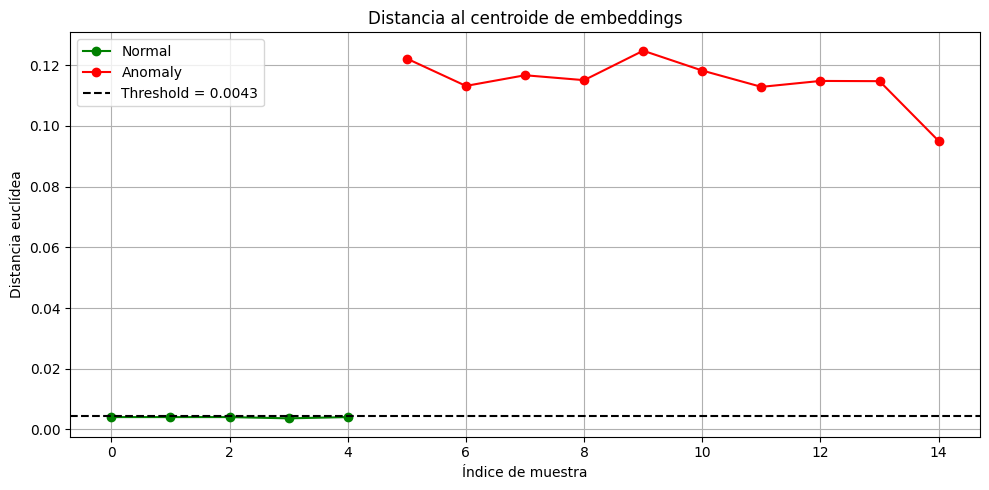

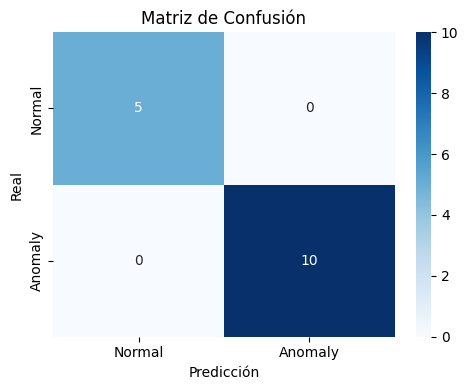

,Métrica,Valor
0,Precision,1.0
1,Recall,1.0
2,F1-score,1.0
3,TP,10.0
4,FP,0.0
5,TN,5.0
6,FN,0.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Etiquetas y predicciones
labels = [0]*len(dist_normal) + [1]*len(dist_anomaly)
distances = dist_normal + dist_anomaly
predictions = [d > threshold for d in distances]

# Métricas
cm = confusion_matrix(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

# ✅ Consola: resumen claro
print("==== RESUMEN DE DETECCIÓN ====")
print(f"True Positives (Anomalías detectadas):     {cm[1,1]}")
print(f"False Positives (Normales mal clasificadas): {cm[0,1]}")
print(f"True Negatives (Normales correctas):         {cm[0,0]}")
print(f"False Negatives (Anomalías no detectadas):   {cm[1,0]}")
print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f}")

# 📈 Gráfica de distancias
plt.figure(figsize=(10,5))
plt.plot(dist_normal, label="Normal", marker="o", color="green")
plt.plot(range(len(dist_normal), len(distances)), dist_anomaly, label="Anomaly", marker="o", color="red")
plt.axhline(threshold, color="black", linestyle="--", label=f"Threshold = {threshold:.4f}")
plt.title("Distancia al centroide de embeddings")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia euclídea")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

# 📋 Tabla resumen
metrics_summary = pd.DataFrame({
    "Métrica": ["Precision", "Recall", "F1-score", "TP", "FP", "TN", "FN"],
    "Valor": [
        round(precision, 2),
        round(recall, 2),
        round(f1, 2),
        cm[1,1],
        cm[0,1],
        cm[0,0],
        cm[1,0]
    ]
})
display(metrics_summary)

En este proyecto implementamos un sistema de detección de anomalías acústicas (Acoustic Anomaly Detection) usando YamNet, una red neuronal convolucional preentrenada desarrollada por Google. YamNet ha sido entrenada con millones de sonidos reales para aprender a extraer representaciones (embeddings) de audio útiles y generales. En lugar de entrenar un modelo desde cero, usamos YamNet como extractor de características acústicas: convertimos cada sonido en un vector numérico que resume su contenido sonoro. Estos vectores (embeddings) permiten comparar sonidos de forma matemática, sin necesidad de clasificarlos explícitamente.

El sistema se basa en la detección de novedades. Primero se extraen los embeddings de sonidos normales y se calcula su centroide, que representa la "firma acústica" de lo que es normal. Luego, para cada nuevo sonido (normal o anómalo), se calcula su distancia al centroide. Si esa distancia es demasiado grande, se considera que el sonido es anómalo. Este enfoque no requiere ejemplos de fallos para entrenar y permite detectar comportamientos acústicos inusuales automáticamente. Todo el código sirve para automatizar este proceso: cargar sonidos, extraer embeddings con YamNet, calcular el centroide, medir distancias y visualizar las detecciones con métricas y gráficas interpretables.

In [ ]:
!pip install tensorflow tensorflow-hub librosa soundfile pandas seaborn tqdm --quiet

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Cargar el modelo preentrenado
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

print("✅ Modelo YamNet cargado desde TensorFlow Hub.")

✅ Modelo YamNet cargado desde TensorFlow Hub.


In [ ]:
import numpy as np
import librosa
import soundfile as sf
import os
import random

os.makedirs("data/normal", exist_ok=True)
os.makedirs("data/anomalous", exist_ok=True)
random.seed(42)

def generate_normal_sound(filename):
    sr = 16000
    t = np.linspace(0, 1, sr)
    freq = random.choice([220, 440, 880])
    signal = 0.5 * np.sin(2 * np.pi * freq * t)
    sf.write(filename, signal, sr)

def generate_anomalous_sound(filename):
    sr = 16000
    t = np.linspace(0, 1, sr)
    noise = np.random.normal(0, 0.5, size=sr)
    signal = 0.5 * np.sin(2 * np.pi * 440 * t) + noise
    sf.write(filename, signal, sr)

for i in range(30):
    generate_normal_sound(f"data/normal/normal_{i}.wav")

for i in range(10):
    generate_anomalous_sound(f"data/anomalous/anomaly_{i}.wav")

print("✅ Audios simulados generados correctamente.")

✅ Audios simulados generados correctamente.


In [ ]:
import glob
normal_files = sorted(glob.glob("data/normal/*.wav"))
print(f"Archivos normales encontrados: {len(normal_files)}")
print("Ejemplos:", normal_files[:3])

Archivos normales encontrados: 30
Ejemplos: ['data/normal/normal_0.wav', 'data/normal/normal_1.wav', 'data/normal/normal_10.wav']


In [ ]:
import librosa
import numpy as np
import glob

def extract_yamnet_embedding(file_path):
    # Cargar audio
    waveform, sr = librosa.load(file_path, sr=16000)
    waveform = waveform[:16000]  # 1 segundo (YamNet espera formas cortas)
    waveform = waveform.astype(np.float32)

    # Ejecutar el modelo YamNet
    scores, embeddings, spectrogram = yamnet_model(waveform)
    embeddings_np = embeddings.numpy()

    # Tomamos la media temporal para reducir a un solo vector
    embedding_mean = np.mean(embeddings_np, axis=0)
    return embedding_mean

# Archivos
normal_files = sorted(glob.glob("data/normal/*.wav"))
anomaly_files = sorted(glob.glob("data/anomalous/*.wav"))

# Extraer embeddings
print("🔍 Extrayendo embeddings con YamNet...")

embeddings_normal = [extract_yamnet_embedding(f) for f in normal_files[:25]]
embeddings_test_normal = [extract_yamnet_embedding(f) for f in normal_files[25:]]
embeddings_test_anomaly = [extract_yamnet_embedding(f) for f in anomaly_files]

print(f"✅ Embeddings extraídos: {len(embeddings_normal)} normales para entrenamiento.")

🔍 Extrayendo embeddings con YamNet...
✅ Embeddings extraídos: 25 normales para entrenamiento.


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Calcular centroide
centroid = np.mean(embeddings_normal, axis=0)

# Calcular distancias
dist_normal = [euclidean_distances(e.reshape(1, -1), centroid.reshape(1, -1))[0,0] for e in embeddings_test_normal]
dist_anomaly = [euclidean_distances(e.reshape(1, -1), centroid.reshape(1, -1))[0,0] for e in embeddings_test_anomaly]

# Umbral
threshold = np.mean(dist_normal) + 2*np.std(dist_normal)

# 📌 Mostrar por consola
print("==== YAMNET - DISTANCIAS ====")
print(f"Centroide: shape = {centroid.shape}")
print(f"Distancias normales → media: {np.mean(dist_normal):.4f}, std: {np.std(dist_normal):.4f}")
print(f"Distancias anómalas → media: {np.mean(dist_anomaly):.4f}, std: {np.std(dist_anomaly):.4f}")
print(f"Umbral de detección: {threshold:.4f}")


==== YAMNET - DISTANCIAS ====
Centroide: shape = (1024,)
Distancias normales → media: 8.1739, std: 1.2941
Distancias anómalas → media: 16.4012, std: 0.3028
Umbral de detección: 10.7621


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

labels = [0]*len(dist_normal) + [1]*len(dist_anomaly)
distances = dist_normal + dist_anomaly
predictions = [d > threshold for d in distances]

# Métricas
cm = confusion_matrix(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

# 📋 Consola
print("==== RESULTADOS DETECCIÓN ====")
print(f"True Positives (anomalías detectadas): {cm[1,1]}")
print(f"False Positives (normales mal clasificadas): {cm[0,1]}")
print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f}")


==== RESULTADOS DETECCIÓN ====
True Positives (anomalías detectadas): 10
False Positives (normales mal clasificadas): 0
Precision: 1.00 | Recall: 1.00 | F1-score: 1.00


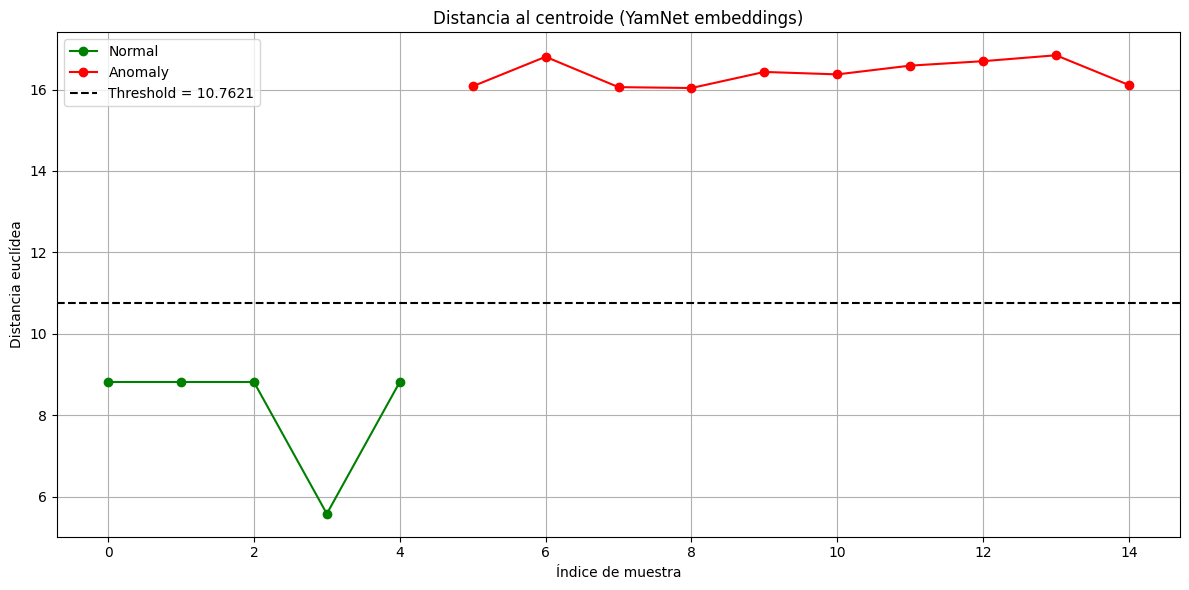

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
plt.plot(dist_normal, label="Normal", marker="o", color="green")
plt.plot(range(len(dist_normal), len(dist_normal)+len(dist_anomaly)), dist_anomaly, label="Anomaly", marker="o", color="red")
plt.axhline(threshold, linestyle="--", color="black", label=f"Threshold = {threshold:.4f}")
plt.title("Distancia al centroide (YamNet embeddings)")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia euclídea")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


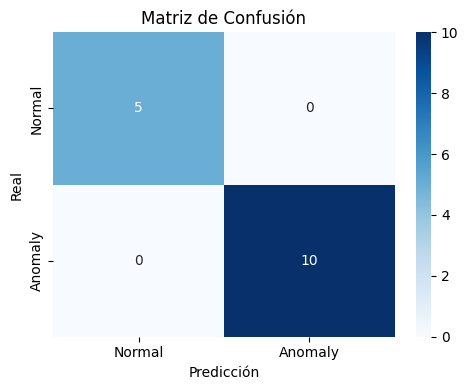

,Métrica,Valor
0,Precision,1.0
1,Recall,1.0
2,F1-score,1.0
3,TP,10.0
4,FP,0.0
5,TN,5.0
6,FN,0.0


In [ ]:
# Matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

# Tabla resumen
metrics_summary = pd.DataFrame({
    "Métrica": ["Precision", "Recall", "F1-score", "TP", "FP", "TN", "FN"],
    "Valor": [
        round(precision, 2),
        round(recall, 2),
        round(f1, 2),
        cm[1,1],
        cm[0,1],
        cm[0,0],
        cm[1,0]
    ]
})
display(metrics_summary)


# Sound Source Localization (SSL)

En este proyecto implementamos una red neuronal convolucional (CNN) para resolver el problema de Sound Source Localization (SSL), es decir, identificar desde qué dirección llega un sonido. Para ello, simulamos señales estéreo con diferencias de tiempo de llegada (delay) entre los canales izquierdo y derecho, representando sonidos que provienen de distintas direcciones: 0°, 90°, 180° y 270°. Estas señales se convierten en espectrogramas log-Mel para ambos canales, que muestran cómo evoluciona la energía en distintas frecuencias a lo largo del tiempo. La red neuronal recibe estos espectrogramas como entrada y aprende a reconocer patrones espaciales y temporales que indican desde qué ángulo llegó el sonido.

La arquitectura utilizada es una CNN 3D ligera, diseñada para procesar entradas con tres dimensiones: canal (izquierdo y derecho), frecuencia y tiempo. Las capas convolucionales extraen automáticamente características relevantes de estos espectrogramas multicanal, y una capa de pooling adaptativo reduce la salida a un vector compacto que pasa por una capa totalmente conectada (fully connected) para producir la clasificación angular. Las CNN son especialmente adecuadas para este tipo de tarea porque pueden aprender patrones espaciales complejos en datos estructurados como imágenes o espectrogramas, sin necesidad de diseñar manualmente características. De este modo, la red aprende a asociar combinaciones temporales y frecuenciales específicas con cada dirección de llegada del sonido.

In [ ]:
!pip install librosa soundfile matplotlib --quiet

In [ ]:
import numpy as np
import soundfile as sf
import os
import random

# Crear carpetas
os.makedirs("ssl_data", exist_ok=True)

# Parámetros
sr = 16000
duration = 1.0
samples = int(sr * duration)
angles = [0, 90, 180, 270]  # ángulos simulados
delay_samples = {
    0: 0,
    90: 10,
    180: 20,
    270: -10
}

def generate_stereo_pair(angle):
    t = np.linspace(0, duration, samples)
    signal = np.sin(2 * np.pi * 440 * t)
    delay = delay_samples[angle]

    if delay >= 0:
        left = np.pad(signal, (delay, 0), mode='constant')[:samples]
        right = signal
    else:
        right = np.pad(signal, (-delay, 0), mode='constant')[:samples]
        left = signal

    return np.stack([left, right], axis=0)

X, y = [], []
print("🔍 Generando señales estéreo simuladas...")
for angle in angles:
    for i in range(50):
        audio = generate_stereo_pair(angle)
        X.append(audio)
        y.append(angles.index(angle))
    print(f"✔️  50 señales generadas para ángulo {angle}° (clase {angles.index(angle)})")

X = np.array(X)
y = np.array(y)

print(f"\n✅ Dataset final: {X.shape[0]} muestras")
print(f"Formato: {X.shape} → (N, 2 canales, {samples} samples)")
print(f"Etiquetas (ángulos como clases): {np.unique(y)}")

🔍 Generando señales estéreo simuladas...
✔️  50 señales generadas para ángulo 0° (clase 0)
✔️  50 señales generadas para ángulo 90° (clase 1)
✔️  50 señales generadas para ángulo 180° (clase 2)
✔️  50 señales generadas para ángulo 270° (clase 3)

✅ Dataset final: 200 muestras
Formato: (200, 2, 16000) → (N, 2 canales, 16000 samples)
Etiquetas (ángulos como clases): [0 1 2 3]


In [ ]:
import librosa

def compute_stereo_spectrograms(X):
    specs = []
    print("🎛️  Extrayendo espectrogramas estéreo...")
    for i in range(X.shape[0]):
        left = librosa.feature.melspectrogram(y=X[i,0], sr=sr, n_mels=64)
        right = librosa.feature.melspectrogram(y=X[i,1], sr=sr, n_mels=64)
        log_left = librosa.power_to_db(left)
        log_right = librosa.power_to_db(right)
        stacked = np.stack([log_left, log_right], axis=0)
        specs.append(stacked)
        if i < 2:  # Mostrar ejemplos
            print(f"📈 Espectrograma muestra {i} | forma: {stacked.shape}")
    return np.array(specs)

X_spec = compute_stereo_spectrograms(X)
print(f"\n✅ Espectrogramas generados: {X_spec.shape}")


🎛️  Extrayendo espectrogramas estéreo...
📈 Espectrograma muestra 0 | forma: (2, 64, 32)
📈 Espectrograma muestra 1 | forma: (2, 64, 32)

✅ Espectrogramas generados: (200, 2, 64, 32)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SSL_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=(2, 3, 3), padding=(0,1,1))
        self.conv2 = nn.Conv3d(8, 16, kernel_size=(1, 3, 3), padding=(0,1,1))
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SSL_CNN().to(device)
print("✅ Red neuronal SSL_CNN inicializada.")

✅ Red neuronal SSL_CNN inicializada.


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X_spec, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train[:, None], dtype=torch.float32)
X_test_tensor = torch.tensor(X_test[:, None], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print("🚀 Entrenando modelo...")
for epoch in range(100):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred_class = torch.argmax(preds, dim=1)
        correct += (pred_class == yb).sum().item()
        total += yb.size(0)
    acc = correct / total
    print(f"📚 Época {epoch+1:02d} | Loss: {total_loss:.4f} | Train Accuracy: {acc:.2f}")

🚀 Entrenando modelo...
📚 Época 01 | Loss: 33.4917 | Train Accuracy: 0.26
📚 Época 02 | Loss: 27.9465 | Train Accuracy: 0.26
📚 Época 03 | Loss: 27.7722 | Train Accuracy: 0.29
📚 Época 04 | Loss: 28.1184 | Train Accuracy: 0.28
📚 Época 05 | Loss: 28.0660 | Train Accuracy: 0.23
📚 Época 06 | Loss: 27.7023 | Train Accuracy: 0.29
📚 Época 07 | Loss: 27.5801 | Train Accuracy: 0.28
📚 Época 08 | Loss: 27.5154 | Train Accuracy: 0.28
📚 Época 09 | Loss: 27.4881 | Train Accuracy: 0.28
📚 Época 10 | Loss: 27.4833 | Train Accuracy: 0.31
📚 Época 11 | Loss: 27.4597 | Train Accuracy: 0.27
📚 Época 12 | Loss: 27.3795 | Train Accuracy: 0.39
📚 Época 13 | Loss: 27.2540 | Train Accuracy: 0.41
📚 Época 14 | Loss: 27.1490 | Train Accuracy: 0.32
📚 Época 15 | Loss: 27.3877 | Train Accuracy: 0.26
📚 Época 16 | Loss: 26.7186 | Train Accuracy: 0.39
📚 Época 17 | Loss: 25.9736 | Train Accuracy: 0.47
📚 Época 18 | Loss: 25.4571 | Train Accuracy: 0.51
📚 Época 19 | Loss: 24.8245 | Train Accuracy: 0.49
📚 Época 20 | Loss: 23.6039 

In [ ]:
model.eval()
correct = 0
total = 0
predicted_angles = []
real_angles = []

print("\n🔍 Predicciones individuales:")
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_classes = torch.argmax(preds, dim=1)
        correct += (pred_classes == yb).sum().item()
        total += yb.size(0)
        predicted_angles.extend(pred_classes.cpu().numpy())
        real_angles.extend(yb.cpu().numpy())

# Mostrar algunas predicciones
angle_map = {0: "0° (frente)", 1: "90° (derecha)", 2: "180° (detrás)", 3: "270° (izquierda)"}
for i in range(10):
    print(f"🎯 Muestra {i+1}: Real = {angle_map[real_angles[i]]} | Predicho = {angle_map[predicted_angles[i]]}")

accuracy = correct / total
print(f"\n✅ Accuracy total en test: {accuracy*100:.2f}%")



🔍 Predicciones individuales:
🎯 Muestra 1: Real = 90° (derecha) | Predicho = 90° (derecha)
🎯 Muestra 2: Real = 0° (frente) | Predicho = 0° (frente)
🎯 Muestra 3: Real = 0° (frente) | Predicho = 0° (frente)
🎯 Muestra 4: Real = 270° (izquierda) | Predicho = 270° (izquierda)
🎯 Muestra 5: Real = 180° (detrás) | Predicho = 180° (detrás)
🎯 Muestra 6: Real = 180° (detrás) | Predicho = 180° (detrás)
🎯 Muestra 7: Real = 90° (derecha) | Predicho = 90° (derecha)
🎯 Muestra 8: Real = 270° (izquierda) | Predicho = 270° (izquierda)
🎯 Muestra 9: Real = 270° (izquierda) | Predicho = 270° (izquierda)
🎯 Muestra 10: Real = 0° (frente) | Predicho = 0° (frente)

✅ Accuracy total en test: 100.00%


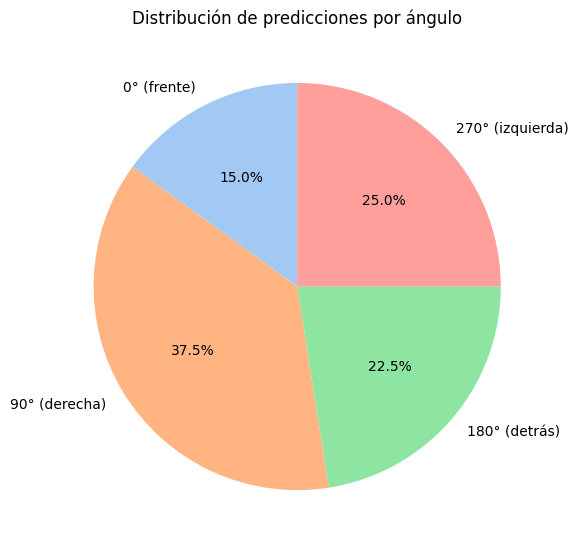

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Contar predicciones por clase
angle_labels = ["0° (frente)", "90° (derecha)", "180° (detrás)", "270° (izquierda)"]
angle_ids = [0, 1, 2, 3]

pred_counter = Counter(predicted_angles)
counts = [pred_counter.get(i, 0) for i in angle_ids]

# Gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(counts, labels=angle_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Distribución de predicciones por ángulo")
plt.tight_layout()
plt.show()

Este sistema implementa una solución híbrida para localización de fuente sonora (Sound Source Localization) combinando una red neuronal preentrenada con un clasificador personalizado. Primero, se simulan señales estéreo (dos canales) con pequeños desplazamientos temporales entre el canal izquierdo y derecho para representar sonidos que provienen de distintas direcciones (0°, 90°, 180°, 270°). Estas señales se convierten a mono para ser procesadas por YamNet, una red neuronal convolucional preentrenada desarrollada por Google y entrenada con millones de muestras de audio del dataset AudioSet. YamNet extrae automáticamente un vector de características de alta calidad (embedding) que resume el contenido acústico del audio de entrada.

A partir de estos embeddings, el sistema entrena un clasificador MLP (Multilayer Perceptron), una red neuronal simple compuesta por capas totalmente conectadas. El MLP aprende a mapear cada vector extraído por YamNet a una de las clases angulares, prediciendo la dirección desde la que proviene el sonido. Todo el proceso está dividido en módulos que permiten ver claramente cómo se genera el dataset, se procesan los audios, se extraen las características y se entrena el modelo. Además, se imprimen resultados por consola y se genera un gráfico de distribución angular para facilitar la interpretación visual del desempeño del sistema. Este enfoque permite aprovechar el poder de una red preentrenada y complementarlo con una red personalizada ligera, logrando una solución efectiva, modular y fácilmente explicable.

In [ ]:
!pip install tensorflow tensorflow-hub librosa soundfile seaborn pandas --quiet
print("✅ Librerías instaladas correctamente.")

✅ Librerías instaladas correctamente.


In [ ]:
import numpy as np
import os
import random

# Parámetros
sr = 16000
duration = 1.0
samples = int(sr * duration)
angles = [0, 90, 180, 270]
delay_samples = {
    0: 0,
    90: 10,
    180: 20,
    270: -10
}

def generate_stereo_pair(angle):
    t = np.linspace(0, duration, samples)
    signal = np.sin(2 * np.pi * 440 * t)
    delay = delay_samples[angle]

    if delay >= 0:
        left = np.pad(signal, (delay, 0), mode='constant')[:samples]
        right = signal
    else:
        right = np.pad(signal, (-delay, 0), mode='constant')[:samples]
        left = signal

    return np.stack([left, right], axis=0)

# Generar dataset
X, y = [], []
print("🎧 Simulando señales estéreo por ángulo:")
for angle in angles:
    for i in range(40):
        audio = generate_stereo_pair(angle)
        X.append(audio)
        y.append(angles.index(angle))
    print(f"✔️  40 muestras generadas para ángulo {angle}° (clase {angles.index(angle)})")

X = np.array(X)
y = np.array(y)

print(f"\n✅ Dataset final: {X.shape[0]} muestras, forma = {X.shape}")

🎧 Simulando señales estéreo por ángulo:
✔️  40 muestras generadas para ángulo 0° (clase 0)
✔️  40 muestras generadas para ángulo 90° (clase 1)
✔️  40 muestras generadas para ángulo 180° (clase 2)
✔️  40 muestras generadas para ángulo 270° (clase 3)

✅ Dataset final: 160 muestras, forma = (160, 2, 16000)


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import librosa

# Forzar uso de CPU para evitar errores
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Cargar modelo
print("🔁 Cargando modelo YamNet desde TensorFlow Hub...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
print("✅ YamNet cargado correctamente.")

# Función de extracción
def extract_embedding_from_stereo(signal):
    waveform = np.mean(signal, axis=0)  # convertir a mono
    waveform = waveform[:16000].astype(np.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return np.mean(embeddings.numpy(), axis=0)

# Extraer embeddings
X_embed = []
print("🔎 Extrayendo embeddings YamNet...")
for i in range(len(X)):
    emb = extract_embedding_from_stereo(X[i])
    X_embed.append(emb)
    if i < 3:
        print(f"📈 Muestra {i} | Embedding shape: {emb.shape} | Clase: {y[i]}")

X_embed = np.array(X_embed)
print(f"\n✅ Embeddings extraídos: {X_embed.shape}")

🔁 Cargando modelo YamNet desde TensorFlow Hub...
✅ YamNet cargado correctamente.
🔎 Extrayendo embeddings YamNet...
📈 Muestra 0 | Embedding shape: (1024,) | Clase: 0
📈 Muestra 1 | Embedding shape: (1024,) | Clase: 0
📈 Muestra 2 | Embedding shape: (1024,) | Clase: 0

✅ Embeddings extraídos: (160, 1024)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YamNetClassifier(nn.Module):
    def __init__(self, input_dim=1024, num_classes=4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YamNetClassifier().to(device)
print("✅ Clasificador MLP inicializado.")

✅ Clasificador MLP inicializado.


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Separar train/test
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, test_size=0.2, random_state=42)

# Tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print("🚀 Entrenando clasificador...")
for epoch in range(100):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
        total += yb.size(0)
    acc = correct / total
    print(f"📚 Epoch {epoch+1:02d} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}")


🚀 Entrenando clasificador...
📚 Epoch 01 | Loss: 22.3030 | Accuracy: 0.23
📚 Epoch 02 | Loss: 21.4748 | Accuracy: 0.38
📚 Epoch 03 | Loss: 20.2813 | Accuracy: 0.48
📚 Epoch 04 | Loss: 18.8239 | Accuracy: 0.42
📚 Epoch 05 | Loss: 16.7987 | Accuracy: 0.59
📚 Epoch 06 | Loss: 14.1443 | Accuracy: 0.68
📚 Epoch 07 | Loss: 12.3234 | Accuracy: 0.66
📚 Epoch 08 | Loss: 10.7483 | Accuracy: 0.72
📚 Epoch 09 | Loss: 9.3176 | Accuracy: 0.73
📚 Epoch 10 | Loss: 8.5887 | Accuracy: 0.74
📚 Epoch 11 | Loss: 7.9326 | Accuracy: 0.70
📚 Epoch 12 | Loss: 6.8559 | Accuracy: 0.72
📚 Epoch 13 | Loss: 6.5800 | Accuracy: 0.70
📚 Epoch 14 | Loss: 6.5219 | Accuracy: 0.74
📚 Epoch 15 | Loss: 6.3671 | Accuracy: 0.73
📚 Epoch 16 | Loss: 6.1386 | Accuracy: 0.71
📚 Epoch 17 | Loss: 6.1394 | Accuracy: 0.70
📚 Epoch 18 | Loss: 6.1197 | Accuracy: 0.70
📚 Epoch 19 | Loss: 6.3113 | Accuracy: 0.72
📚 Epoch 20 | Loss: 6.1495 | Accuracy: 0.74
📚 Epoch 21 | Loss: 5.9459 | Accuracy: 0.77
📚 Epoch 22 | Loss: 6.2366 | Accuracy: 0.73
📚 Epoch 23 | Loss

In [ ]:
model.eval()
correct = 0
total = 0
preds_list = []
true_list = []

print("\n🔍 Predicciones individuales (10 ejemplos):")
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        predicted = preds.argmax(1)
        preds_list.extend(predicted.cpu().numpy())
        true_list.extend(yb.cpu().numpy())
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

# Imprimir primeras predicciones
angle_map = {0: "0° (frente)", 1: "90° (derecha)", 2: "180° (detrás)", 3: "270° (izquierda)"}
for i in range(10):
    print(f"🎯 Muestra {i+1}: Real = {angle_map[true_list[i]]} | Predicho = {angle_map[preds_list[i]]}")

acc = correct / total
print(f"\n✅ Precisión total en test: {acc * 100:.2f}%")



🔍 Predicciones individuales (10 ejemplos):
🎯 Muestra 1: Real = 180° (detrás) | Predicho = 180° (detrás)
🎯 Muestra 2: Real = 180° (detrás) | Predicho = 180° (detrás)
🎯 Muestra 3: Real = 270° (izquierda) | Predicho = 90° (derecha)
🎯 Muestra 4: Real = 90° (derecha) | Predicho = 90° (derecha)
🎯 Muestra 5: Real = 180° (detrás) | Predicho = 180° (detrás)
🎯 Muestra 6: Real = 0° (frente) | Predicho = 0° (frente)
🎯 Muestra 7: Real = 180° (detrás) | Predicho = 180° (detrás)
🎯 Muestra 8: Real = 90° (derecha) | Predicho = 90° (derecha)
🎯 Muestra 9: Real = 180° (detrás) | Predicho = 180° (detrás)
🎯 Muestra 10: Real = 270° (izquierda) | Predicho = 90° (derecha)

✅ Precisión total en test: 78.12%


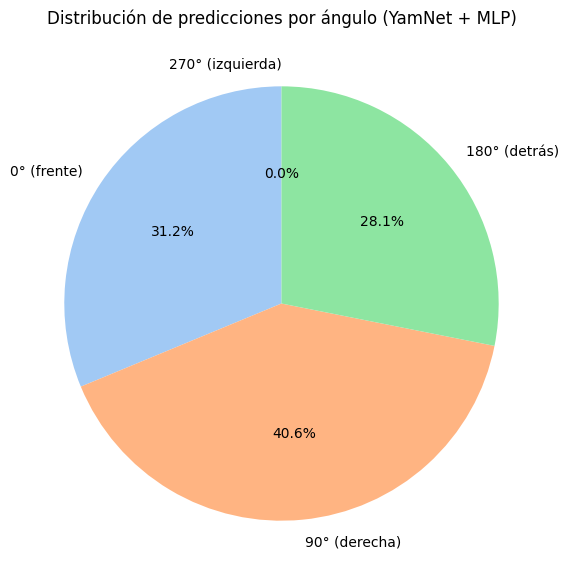

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

counts = Counter(preds_list)
labels = ["0° (frente)", "90° (derecha)", "180° (detrás)", "270° (izquierda)"]
values = [counts.get(i, 0) for i in range(4)]

plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Distribución de predicciones por ángulo (YamNet + MLP)")
plt.tight_layout()
plt.show()

# Bioacoustics

En este proyecto estamos trabajando con un subconjunto del dataset BirdCLEF 2024, compuesto por grabaciones cortas (5 segundos) de cantos de aves, organizadas por especie. Hemos realizado una exploración inicial del dataset (mini-EDA), donde identificamos que existen más de 180 especies, y seleccionamos las 5 con mayor número de audios para construir un conjunto equilibrado y manejable. Posteriormente, extraemos espectrogramas mel de los audios —representaciones visuales del contenido frecuencial de las señales— que sirven como entrada para redes neuronales. Estos espectrogramas encapsulan patrones temporales y frecuenciales característicos de cada especie, convirtiendo el problema en una tarea de clasificación de imágenes.

Para abordar esta tarea, utilizaremos una Convolutional Neural Network (CNN), una arquitectura especialmente adecuada para tratar datos con estructura espacial como los espectrogramas. Las CNNs aprenden automáticamente filtros convolucionales que detectan características relevantes en distintas escalas (frecuencias, transiciones, texturas), lo que permite capturar los "rasgos acústicos" propios de cada especie. La red tomará como entrada los espectrogramas procesados y aprenderá a predecir la especie correspondiente. Dividiremos el dataset en conjuntos de entrenamiento y validación para evaluar el rendimiento y, una vez entrenado, podremos usar el modelo para clasificar nuevas grabaciones de cantos de aves.



In [ ]:
!pip install kagglehub librosa torch torchvision torchaudio matplotlib seaborn tqdm pandas scikit-learn --quiet

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samvelkoch/birdclef-2024-5-seconds-chunks")

print("Path to dataset files:", path)

100%|██████████| 7.72G/7.72G [06:04<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samvelkoch/birdclef-2024-5-seconds-chunks/versions/1


📁 Carpeta del dataset: /root/.cache/kagglehub/datasets/samvelkoch/birdclef-2024-5-seconds-chunks/versions/1
🎧 Total de archivos de audio encontrados: 212441
🦜 Número total de especies: 182

📊 Top 10 especies con más audios:
   Especie  Cantidad
0  blrwar1     19911
1   houspa      9042
2  grewar3      6709
3   commyn      6317
4   hoopoe      5826
5   comros      5485
6   eucdov      4776
7   bkwsti      4505
8  graher1      4195
9   barswa      4172


<ipython-input-6-c479ab05ac25>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x="Especie", y="Cantidad", palette="viridis")
<ipython-input-6-c479ab05ac25>:37: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


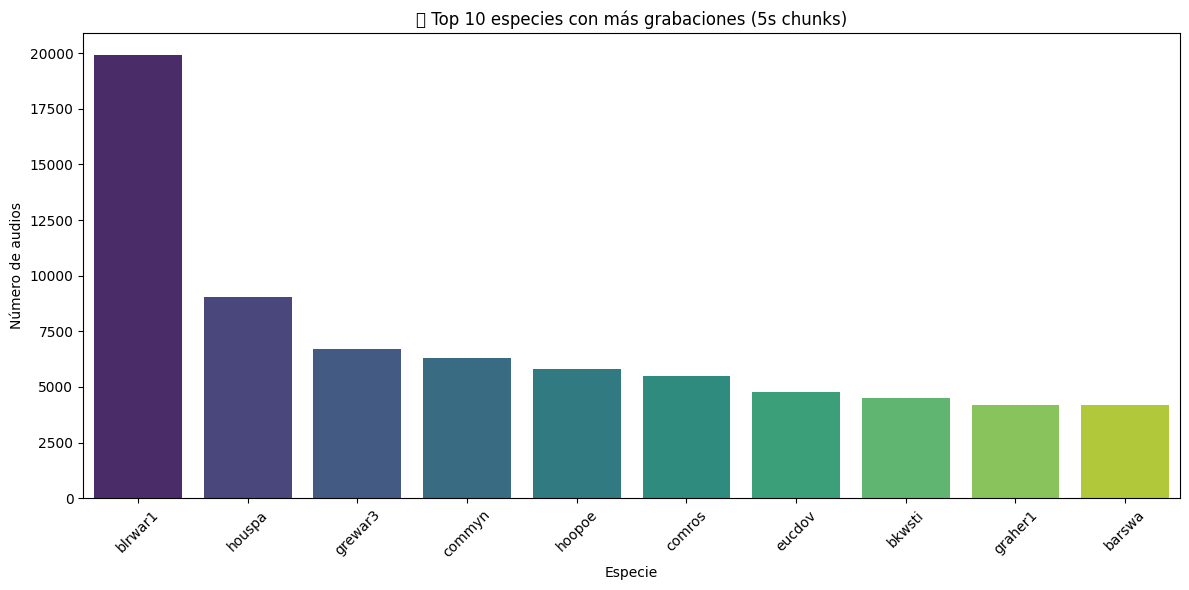

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Ruta base descargada con kagglehub
print(f"📁 Carpeta del dataset: {path}")

# Buscar todos los archivos de audio (.ogg o .wav)
audio_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".ogg") or file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"🎧 Total de archivos de audio encontrados: {len(audio_files)}")

# Extraer especies desde la carpeta (se asume estructura: path/especie/archivo.ogg)
species_list = [os.path.basename(os.path.dirname(f)) for f in audio_files]
species_counter = Counter(species_list)

# Convertir a DataFrame
df = pd.DataFrame(species_counter.items(), columns=["Especie", "Cantidad"])
df = df.sort_values("Cantidad", ascending=False).reset_index(drop=True)

print(f"🦜 Número total de especies: {df.shape[0]}")
print("\n📊 Top 10 especies con más audios:")
print(df.head(10))

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=df.head(10), x="Especie", y="Cantidad", palette="viridis")
plt.title("🎼 Top 10 especies con más grabaciones (5s chunks)")
plt.ylabel("Número de audios")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from glob import glob
import pandas as pd
import random

# Definimos las 5 especies con más audios
selected_species = ['blrwar1', 'houspa', 'grewar3', 'commyn', 'hoopoe']
print("🎯 Especies seleccionadas:", selected_species)

# Recoger 50 archivos por especie
audio_files = []
labels = []

for species in selected_species:
    species_path = os.path.join(path, species)
    files = glob(os.path.join(species_path, "*.ogg"))
    selected = files[:50]  # hasta 50
    audio_files.extend(selected)
    labels.extend([species] * len(selected))

print(f"🎵 Total de audios seleccionados: {len(audio_files)}")

🎯 Especies seleccionadas: ['blrwar1', 'houspa', 'grewar3', 'commyn', 'hoopoe']
🎵 Total de audios seleccionados: 250


In [ ]:
import librosa
import numpy as np
from tqdm import tqdm

def extract_spectrogram(filepath, sr=22050, duration=5):
    y, _ = librosa.load(filepath, sr=sr, duration=duration)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    return librosa.power_to_db(mel, ref=np.max)

spectrograms = []
valid_labels = []

print("🔍 Extrayendo espectrogramas...")
for i, file in enumerate(tqdm(audio_files)):
    try:
        spec = extract_spectrogram(file)
        if spec.shape[1] >= 128:
            spectrograms.append(spec[:, :128])
            valid_labels.append(labels[i])
        else:
            print(f"⚠️ Espectrograma corto: {file}")
    except Exception as e:
        print(f"❌ Error procesando {file}: {e}")

🔍 Extrayendo espectrogramas...


 31%|███       | 78/250 [00:04<00:12, 14.01it/s]

⚠️ Espectrograma corto: /root/.cache/kagglehub/datasets/samvelkoch/birdclef-2024-5-seconds-chunks/versions/1/houspa/XC818666_8.ogg


 45%|████▌     | 113/250 [00:06<00:04, 32.81it/s]

⚠️ Espectrograma corto: /root/.cache/kagglehub/datasets/samvelkoch/birdclef-2024-5-seconds-chunks/versions/1/grewar3/XC792613_5.ogg


100%|██████████| 250/250 [00:10<00:00, 23.90it/s]

⚠️ Espectrograma corto: /root/.cache/kagglehub/datasets/samvelkoch/birdclef-2024-5-seconds-chunks/versions/1/hoopoe/XC560357_22.ogg


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch

# Expandir dimensión y convertir a tensores
X = np.array(spectrograms)[:, np.newaxis, :, :]
y = np.array(valid_labels)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42)

print("✅ Datos preparados:")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test:", X_test.shape, "| y_test:", y_test.shape)


✅ Datos preparados:
X_train: torch.Size([197, 1, 128, 128]) | y_train: torch.Size([197])
X_test: torch.Size([50, 1, 128, 128]) | y_test: torch.Size([50])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BirdCNN(nn.Module):
    def __init__(self, num_classes):
        super(BirdCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.adapt = nn.AdaptiveAvgPool2d((8, 8))
        self.fc1 = nn.Linear(16*8*8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.adapt(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = BirdCNN(num_classes=len(le.classes_))
print("✅ Modelo definido:")
print(model)


✅ Modelo definido:
BirdCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adapt): AdaptiveAvgPool2d(output_size=(8, 8))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("🚀 Iniciando entrenamiento:")
for epoch in range(200):
    model.train()
    total_loss = 0
    correct = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == yb).sum().item()
    acc = 100 * correct / len(y_train)
    print(f"📚 Época {epoch+1}: Pérdida = {total_loss:.4f} | Precisión = {acc:.2f}%")


🚀 Iniciando entrenamiento:
📚 Época 1: Pérdida = 63.2236 | Precisión = 20.81%
📚 Época 2: Pérdida = 42.7130 | Precisión = 22.34%
📚 Época 3: Pérdida = 41.1205 | Precisión = 19.80%
📚 Época 4: Pérdida = 35.5402 | Precisión = 41.62%
📚 Época 5: Pérdida = 34.2149 | Precisión = 45.18%
📚 Época 6: Pérdida = 33.2539 | Precisión = 43.65%
📚 Época 7: Pérdida = 31.2625 | Precisión = 47.72%
📚 Época 8: Pérdida = 32.3298 | Precisión = 45.69%
📚 Época 9: Pérdida = 30.0689 | Precisión = 49.75%
📚 Época 10: Pérdida = 29.7478 | Precisión = 52.79%
📚 Época 11: Pérdida = 30.0740 | Precisión = 49.24%
📚 Época 12: Pérdida = 28.3418 | Precisión = 51.78%
📚 Época 13: Pérdida = 27.7832 | Precisión = 56.35%
📚 Época 14: Pérdida = 27.4026 | Precisión = 58.88%
📚 Época 15: Pérdida = 25.8723 | Precisión = 63.45%
📚 Época 16: Pérdida = 26.7241 | Precisión = 57.87%
📚 Época 17: Pérdida = 27.7105 | Precisión = 58.88%
📚 Época 18: Pérdida = 26.1116 | Precisión = 56.85%
📚 Época 19: Pérdida = 26.1622 | Precisión = 55.84%
📚 Época 20: P

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(1)
    acc = 100 * (predicted == y_test).sum().item() / len(y_test)
    print(f"\n✅ Precisión en conjunto de prueba: {acc:.2f}%\n")

    print("🎼 Predicciones:")
    for i in range(min(10, len(y_test))):
        real = le.inverse_transform([y_test[i].item()])[0]
        pred = le.inverse_transform([predicted[i].item()])[0]
        print(f"Ejemplo {i+1}: Real = {real} | Predicho = {pred}")



✅ Precisión en conjunto de prueba: 66.00%

🎼 Predicciones:
Ejemplo 1: Real = hoopoe | Predicho = blrwar1
Ejemplo 2: Real = blrwar1 | Predicho = grewar3
Ejemplo 3: Real = commyn | Predicho = commyn
Ejemplo 4: Real = commyn | Predicho = commyn
Ejemplo 5: Real = blrwar1 | Predicho = hoopoe
Ejemplo 6: Real = houspa | Predicho = houspa
Ejemplo 7: Real = hoopoe | Predicho = hoopoe
Ejemplo 8: Real = commyn | Predicho = commyn
Ejemplo 9: Real = hoopoe | Predicho = hoopoe
Ejemplo 10: Real = commyn | Predicho = commyn


<ipython-input-24-43d7f266868f>:17: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


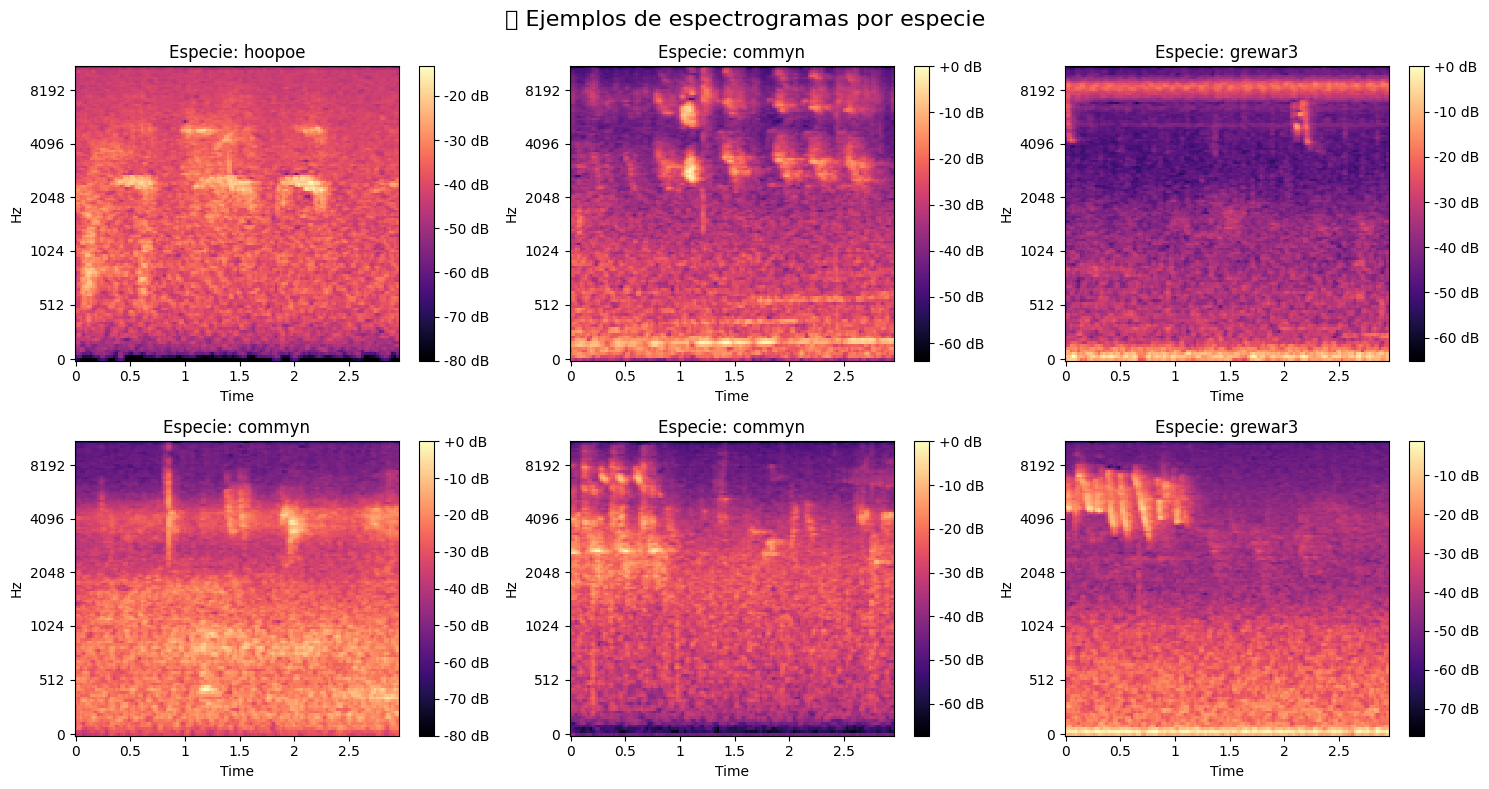

In [ ]:
import matplotlib.pyplot as plt
import random

# Seleccionamos N muestras aleatorias para mostrar
N = 6
indices = random.sample(range(len(spectrograms)), N)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(2, 3, i + 1)
    librosa.display.specshow(spectrograms[idx], sr=22050, x_axis='time', y_axis='mel')
    plt.title(f"Especie: {labels[idx]}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

plt.suptitle("🎶 Ejemplos de espectrogramas por especie", fontsize=16)
plt.tight_layout()
plt.show()